In [1]:
import sys
from pathlib import Path

# Add src to path
src_path = Path.cwd().parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

In [2]:
import pandas as pd
import numpy as np

# Simulation based method for optimal trading rule
To compute the optimal trading rule under model (2) for
all of the trading strategies, I propose to select the optimal
boundaries (i.e. for U and L; I setC as the mean of the
spread by default† ) based on the Monte Carlo simulation of
the spread (Equation (2) given the estimation of the unknown
parameters).

On utilisera les spécifications suivantes du modèle (2) 

- **Model 1**: Linear + Gaussian + Homoscedastic: $x_{t+1} = 0.959 x_t + 0.0049 \eta_t$
- **Model 2**: Nonlinear + Gaussian: $x_{t+1} = 0.9 x_t + 0.259 x_t^2 + 0.0049 \eta_t$
- **Model 3**: Linear + Heteroscedastic: $x_{t+1} = 0.959 x_t + \sqrt{0.00089 + 0.08 x_t^2} \eta_t$
- **Model 4**: Linear + t-distributed: $x_{t+1} = 0.959 x_t + \frac{0.0049}{\sqrt{3}} \eta_t$, $\eta_t \sim t(3)$
- **Model 5**: Nonlinear + t-distributed: $x_{t+1} = 0.9 x_t + 0.259 x_t^2 + \frac{0.0049}{\sqrt{3}} \eta_t$, $\eta_t \sim t(3)$

### Simulation Parameters:
- T = 1000 trading days (~4 years)
- N = 10,000 Monte Carlo paths
- Grid: U ∈ [0.1, 2.5]σ, L ∈ [-2.5, -0.1]σ (step 0.1)
- Transaction cost: 20bp per asset (40bp round-trip)

In [3]:
# =============================================================================
# Table 1 Replication from Zhang (2021)
# Using optimized numba module for fast computation
# =============================================================================

from simul.optimization import replicate_table1, PAPER_TABLE1, NUMBA_AVAILABLE

print(f"Numba available: {NUMBA_AVAILABLE}")
print("\nThis will replicate Table 1: Optimal Trading Rules for Models 1-5")
print("Using N=10,000 Monte Carlo simulations, T=1000 days")
print("Transaction cost: 20bp per asset (40bp round-trip)")
print("\n⏱️ Expected runtime: ~30 sec with numba, longer without")

Numba available: True

This will replicate Table 1: Optimal Trading Rules for Models 1-5
Using N=10,000 Monte Carlo simulations, T=1000 days
Transaction cost: 20bp per asset (40bp round-trip)

⏱️ Expected runtime: ~30 sec with numba, longer without


In [4]:
# =============================================================================
# Run Table 1 Optimization
# =============================================================================
import time

# Run with full paper parameters
N_SIMS = 10000  # Paper uses 10,000, we use 2000 for faster computation
T_DAYS = 1000   # ~4 years

start_time = time.time()
all_results = replicate_table1(N=N_SIMS, T=T_DAYS, cost_bp=20.0, verbose=True)
total_time = time.time() - start_time

print(f"\n⏱️ Total computation time: {total_time:.1f}s")
print("Expected run time: ")

Replicating Table 1: N=10000, T=1000, cost=20.0bp
Numba available: True

MODEL1
  Paths simulated in 2.1s (C=0.000006, σ=0.016668)
  Strategy A (6.3s): CR: U*=0.7σ, L*=-0.7σ, CR=0.3895 | SR: U*=1.2σ, L*=-1.2σ, SR=0.1009
  Strategy B (9.3s): CR: U*=0.6σ, L*=-0.6σ, CR=0.4318 | SR: U*=0.6σ, L*=-0.6σ, SR=0.0896
  Strategy C (10.8s): CR: U*=1.1σ, L*=-1.1σ, CR=0.2983 | SR: U*=0.9σ, L*=-0.9σ, SR=0.1303

MODEL2
  Paths simulated in 1.2s (C=0.000325, σ=0.011088)
  Strategy A (6.9s): CR: U*=0.7σ, L*=-0.7σ, CR=0.5583 | SR: U*=1.1σ, L*=-1.1σ, SR=0.1459
  Strategy B (9.9s): CR: U*=0.6σ, L*=-0.6σ, CR=0.6322 | SR: U*=0.5σ, L*=-0.6σ, SR=0.1320
  Strategy C (10.1s): CR: U*=1.2σ, L*=-1.2σ, CR=0.3280 | SR: U*=1.2σ, L*=-1.1σ, SR=0.1429

MODEL3
  Paths simulated in 0.9s (C=0.000439, σ=0.189010)
  Strategy A (6.9s): CR: U*=0.2σ, L*=-0.2σ, CR=3.9971 | SR: U*=0.2σ, L*=-0.3σ, SR=0.0771
  Strategy B (7.8s): CR: U*=0.1σ, L*=-0.1σ, CR=4.0676 | SR: U*=0.1σ, L*=-0.1σ, SR=0.0756
  Strategy C (12.7s): CR: U*=0.5σ, L*

In [5]:
# =============================================================================
# Format as Table 1 (matching paper format)
# =============================================================================

models = ['model1', 'model2', 'model3', 'model4', 'model5']
strategies = ['A', 'B', 'C']

# Create DataFrame
table1_data = []
for model in models:
    for strategy in strategies:
        res = all_results[(model, strategy)]
        table1_data.append({
            'Model': model.replace('model', 'Model '),
            'Strategy': strategy,
            'U* (CR)': res.U_star_cr,
            'L* (CR)': res.L_star_cr,
            'CR': res.CR,
            'U* (SR)': res.U_star_sr,
            'L* (SR)': res.L_star_sr,
            'SR': res.SR
        })

table1 = pd.DataFrame(table1_data)

# Display
print("\n" + "=" * 90)
print("TABLE 1: Optimal Selection of Trading Rule for Cumulative Return and Sharpe Ratio")
print("=" * 90)
print(f"\nN = {N_SIMS} simulations, T = {T_DAYS} days, Cost = 20bp per asset")
print("U* and L* are in units of σ (standard deviations from mean)")
print("-" * 90)
print(table1.to_string(index=False, float_format=lambda x: f'{x:.4f}' if abs(x) < 10 else f'{x:.2f}'))
print("-" * 90)


TABLE 1: Optimal Selection of Trading Rule for Cumulative Return and Sharpe Ratio

N = 10000 simulations, T = 1000 days, Cost = 20bp per asset
U* and L* are in units of σ (standard deviations from mean)
------------------------------------------------------------------------------------------
  Model Strategy  U* (CR)  L* (CR)     CR  U* (SR)  L* (SR)     SR
Model 1        A   0.7000  -0.7000 0.3895   1.2000  -1.2000 0.1009
Model 1        B   0.6000  -0.6000 0.4318   0.6000  -0.6000 0.0896
Model 1        C   1.1000  -1.1000 0.2983   0.9000  -0.9000 0.1303
Model 2        A   0.7000  -0.7000 0.5583   1.1000  -1.1000 0.1459
Model 2        B   0.6000  -0.6000 0.6322   0.5000  -0.6000 0.1320
Model 2        C   1.2000  -1.2000 0.3280   1.2000  -1.1000 0.1429
Model 3        A   0.2000  -0.2000 3.9971   0.2000  -0.3000 0.0771
Model 3        B   0.1000  -0.1000 4.0676   0.1000  -0.1000 0.0756
Model 3        C   0.5000  -0.5000 4.2953   0.4000  -0.4000 0.2064
Model 4        A   0.6000  -0.6000 

In [6]:
# =============================================================================
# Comparison with Paper's Table 1
# =============================================================================

# Reference values from Zhang (2021)
paper_data = []
for (model, strat), vals in PAPER_TABLE1.items():
    paper_data.append({
        'Model': model.replace('model', 'Model '),
        'Strategy': strat,
        'U* (CR)': vals['U_cr'],
        'L* (CR)': vals['L_cr'],
        'CR': vals['CR'],
        'U* (SR)': vals['U_sr'],
        'L* (SR)': vals['L_sr'],
        'SR': vals['SR']
    })

paper_table1 = pd.DataFrame(paper_data)

print("\n" + "=" * 90)
print("REFERENCE: Paper's Table 1 (Zhang 2021)")
print("=" * 90)
print(paper_table1.to_string(index=False, float_format=lambda x: f'{x:.4f}' if abs(x) < 10 else f'{x:.2f}'))
print("-" * 90)

# Summary comparison
print("\n📊 COMPARISON SUMMARY:")
print("-" * 60)
for model in models:
    model_label = model.replace('model', 'Model ')
    our_rows = table1[table1['Model'] == model_label]
    paper_rows = paper_table1[paper_table1['Model'] == model_label]
    
    our_cr = our_rows['CR'].mean()
    paper_cr = paper_rows['CR'].mean()
    diff_pct = (our_cr - paper_cr) / paper_cr * 100
    
    print(f"{model_label}: Our avg CR = {our_cr:.4f}, Paper = {paper_cr:.4f} ({diff_pct:+.1f}%)")


REFERENCE: Paper's Table 1 (Zhang 2021)
  Model Strategy  U* (CR)  L* (CR)     CR  U* (SR)  L* (SR)     SR
Model 1        A   0.7000  -0.7000 0.3868   1.1000  -1.1000 0.0882
Model 1        B   0.5000  -0.5000 0.4245   0.5000  -0.5000 0.0807
Model 1        C   1.0000  -1.0000 0.2990   0.9000  -0.9000 0.1044
Model 2        A   0.8000  -0.8000 0.5562   1.2000  -1.3000 0.1308
Model 2        B   0.6000  -0.6000 0.6085   0.6000  -0.6000 0.1203
Model 2        C   1.2000  -1.3000 0.3300   1.2000  -1.3000 0.1163
Model 3        A   0.3000  -0.2000 3.9413   0.4000  -0.4000 0.0751
Model 3        B   0.1000  -0.1000 4.0139   0.1000  -0.1000 0.0743
Model 3        C   0.8000  -0.8000 6.6763   0.1000  -0.1000 0.2499
Model 4        A   0.6000  -0.6000 0.3792   1.0000  -1.0000 0.0881
Model 4        B   0.4000  -0.5000 0.4071   0.5000  -0.5000 0.0782
Model 4        C   1.0000  -1.0000 0.2243   1.0000  -1.0000 0.0829
Model 5        A   0.7000  -0.7000 0.5359   1.2000  -1.2000 0.1293
Model 5        B   0.

In [7]:

# Find best performers
best_cr = table1.loc[table1['CR'].idxmax()]
best_sr = table1.loc[table1['SR'].idxmax()]

print(f"\n🏆 BEST PERFORMERS (Our Results):")
print(f"   Highest CR: {best_cr['Model']}, Strategy {best_cr['Strategy']} → CR = {best_cr['CR']:.4f}")
print(f"   Highest SR: {best_sr['Model']}, Strategy {best_sr['Strategy']} → SR = {best_sr['SR']:.4f}")


🏆 BEST PERFORMERS (Our Results):
   Highest CR: Model 3, Strategy C → CR = 4.2953
   Highest SR: Model 3, Strategy C → SR = 0.2064


In [8]:
# =============================================================================
# 3D Surface Plots: CR and SR for all Models (Figures A1-A5 from paper)
# =============================================================================
from mpl_toolkits.mplot3d import Axes3D
from simul.optimization.table1 import simulate_paths, _grid_search_numba
import matplotlib.pyplot as plt

# Grid definition
U_grid = np.arange(0.1, 2.55, 0.1)
L_grid = np.arange(-2.5, -0.05, 0.1)
tc = 20 / 10000  # 20bp per trade (paper: "40bp round-trip" = 20bp per asset)

# Meshgrid for plotting
L_mesh, U_mesh = np.meshgrid(L_grid, U_grid)

# Compute surfaces for all models (using N=2000 for speed)
N_SURF = 2000
surfaces = {}

print("Computing CR/SR surfaces for all models...")
for model in ['model1', 'model2', 'model3', 'model4', 'model5']:
    print(f"  {model}...", end=" ", flush=True)
    paths, C, sigma = simulate_paths(model, N_SURF, 1000, seed=42)
    
    surfaces[model] = {}
    for strat_name, strat_id in [('A', 1), ('B', 2), ('C', 3)]:
        CR_arr, SR_arr = _grid_search_numba(paths, C, sigma, U_grid, L_grid, strat_id, tc)
        CR_matrix = CR_arr.reshape(len(U_grid), len(L_grid))
        SR_matrix = SR_arr.reshape(len(U_grid), len(L_grid))
        # Replace -inf with nan for plotting
        CR_matrix[CR_matrix == -np.inf] = np.nan
        SR_matrix[SR_matrix == -np.inf] = np.nan
        surfaces[model][strat_name] = {'CR': CR_matrix, 'SR': SR_matrix}
    print("done")

print("\n✅ All surfaces computed!")

Computing CR/SR surfaces for all models...
  model1... done
  model2... done
  model3... done
  model4... done
  model5... done

✅ All surfaces computed!


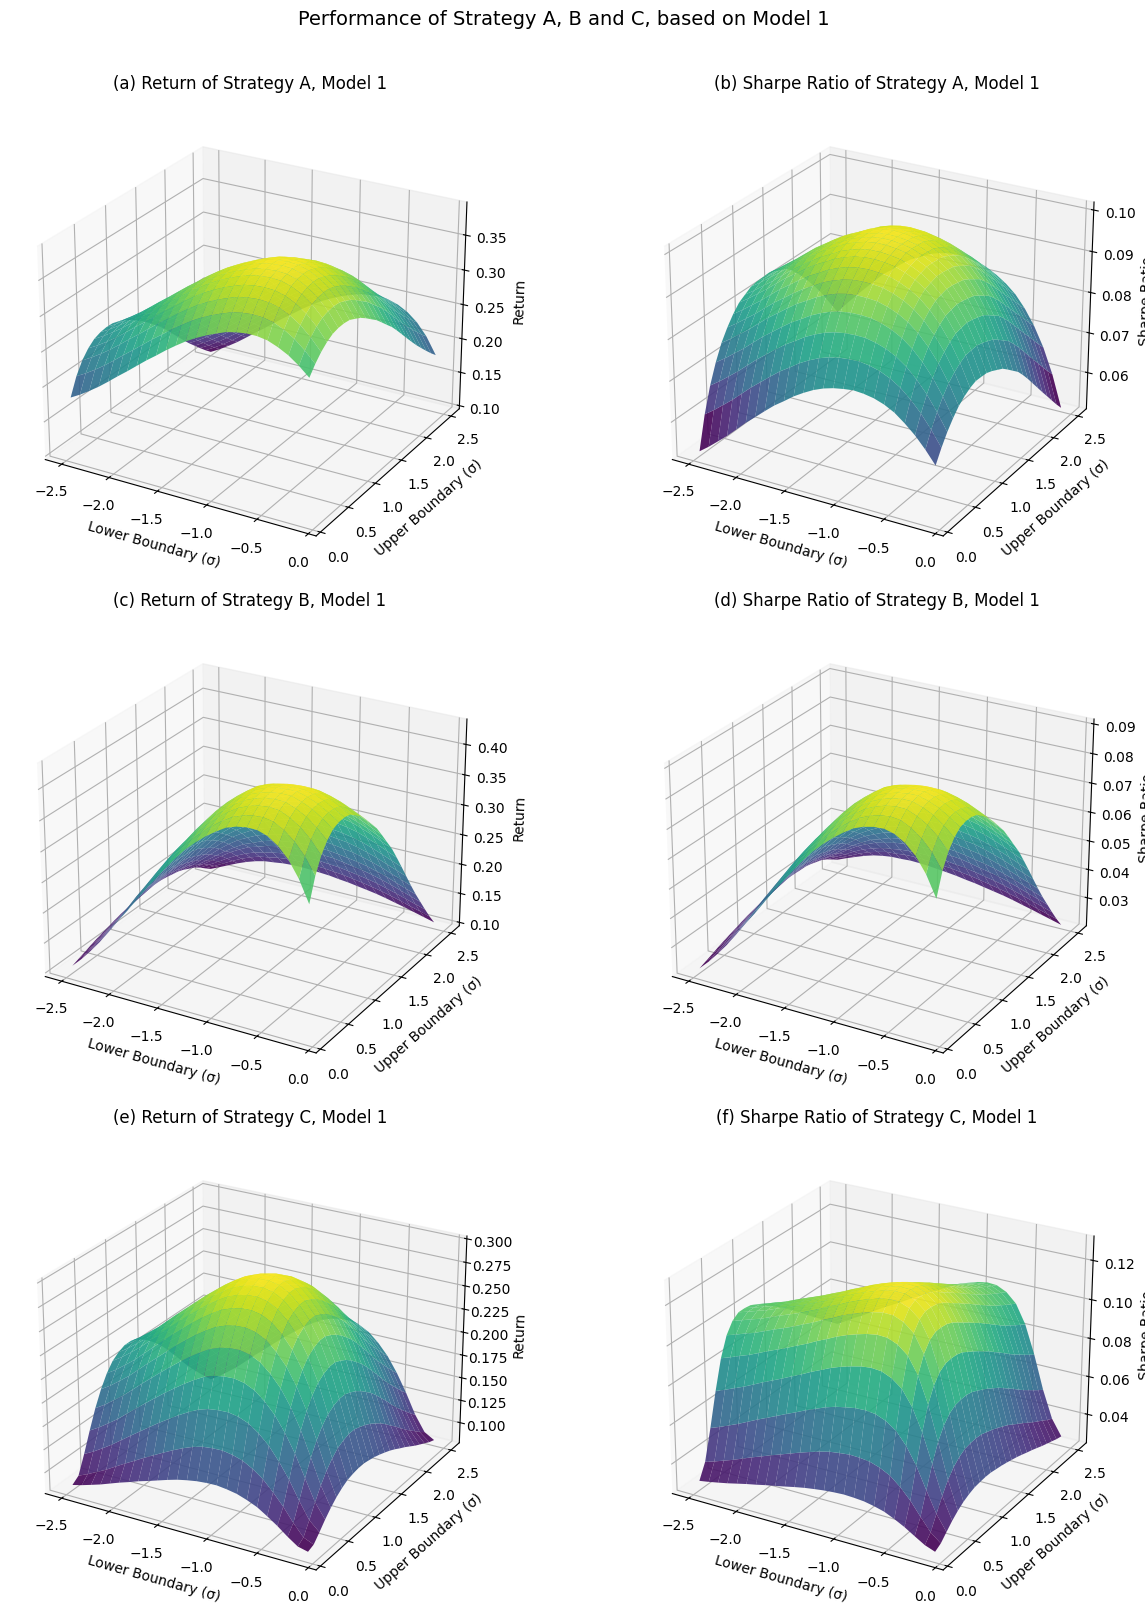

In [9]:
# =============================================================================
# Plot 3D Surfaces for each Model (like Figures A1-A5)
# =============================================================================

def plot_model_surfaces(model_name, surfaces_data):
    """Create 3x2 subplot with CR and SR surfaces for strategies A, B, C"""
    fig = plt.figure(figsize=(14, 16))
    
    strategies = ['A', 'B', 'C']
    
    for i, strat in enumerate(strategies):
        # CR surface (left column)
        ax1 = fig.add_subplot(3, 2, 2*i + 1, projection='3d')
        CR = surfaces_data[strat]['CR']
        surf1 = ax1.plot_surface(L_mesh, U_mesh, CR, cmap='viridis', 
                                  edgecolor='none', alpha=0.9)
        ax1.set_xlabel('Lower Boundary (σ)')
        ax1.set_ylabel('Upper Boundary (σ)')
        ax1.set_zlabel('Return')
        ax1.set_title(f'({chr(97+2*i)}) Return of Strategy {strat}, {model_name}')
        ax1.view_init(elev=25, azim=-60)
        
        # SR surface (right column)
        ax2 = fig.add_subplot(3, 2, 2*i + 2, projection='3d')
        SR = surfaces_data[strat]['SR']
        surf2 = ax2.plot_surface(L_mesh, U_mesh, SR, cmap='viridis', 
                                  edgecolor='none', alpha=0.9)
        ax2.set_xlabel('Lower Boundary (σ)')
        ax2.set_ylabel('Upper Boundary (σ)')
        ax2.set_zlabel('Sharpe Ratio')
        ax2.set_title(f'({chr(98+2*i)}) Sharpe Ratio of Strategy {strat}, {model_name}')
        ax2.view_init(elev=25, azim=-60)
    
    fig.suptitle(f'Performance of Strategy A, B and C, based on {model_name}', 
                 fontsize=14, y=1.01)
    plt.tight_layout()
    return fig

# Plot Model 1
fig1 = plot_model_surfaces('Model 1', surfaces['model1'])
plt.show()

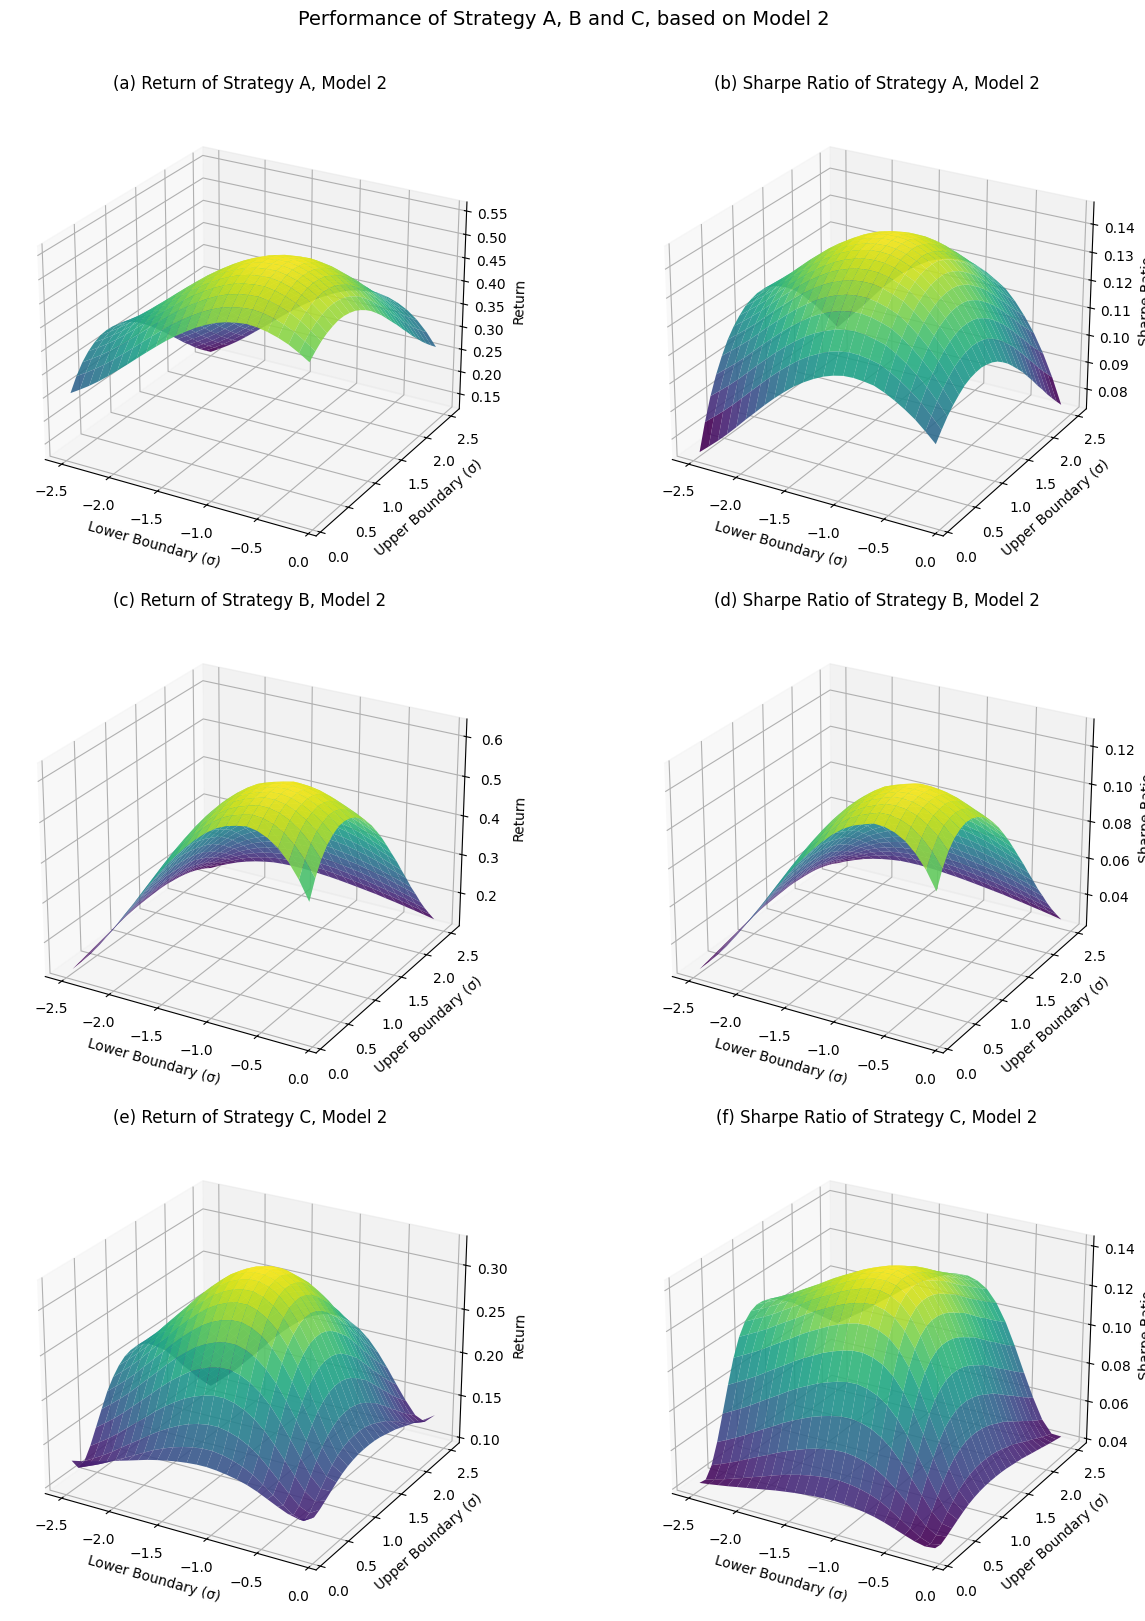

In [10]:
# Plot Model 2
fig2 = plot_model_surfaces('Model 2', surfaces['model2'])
plt.show()

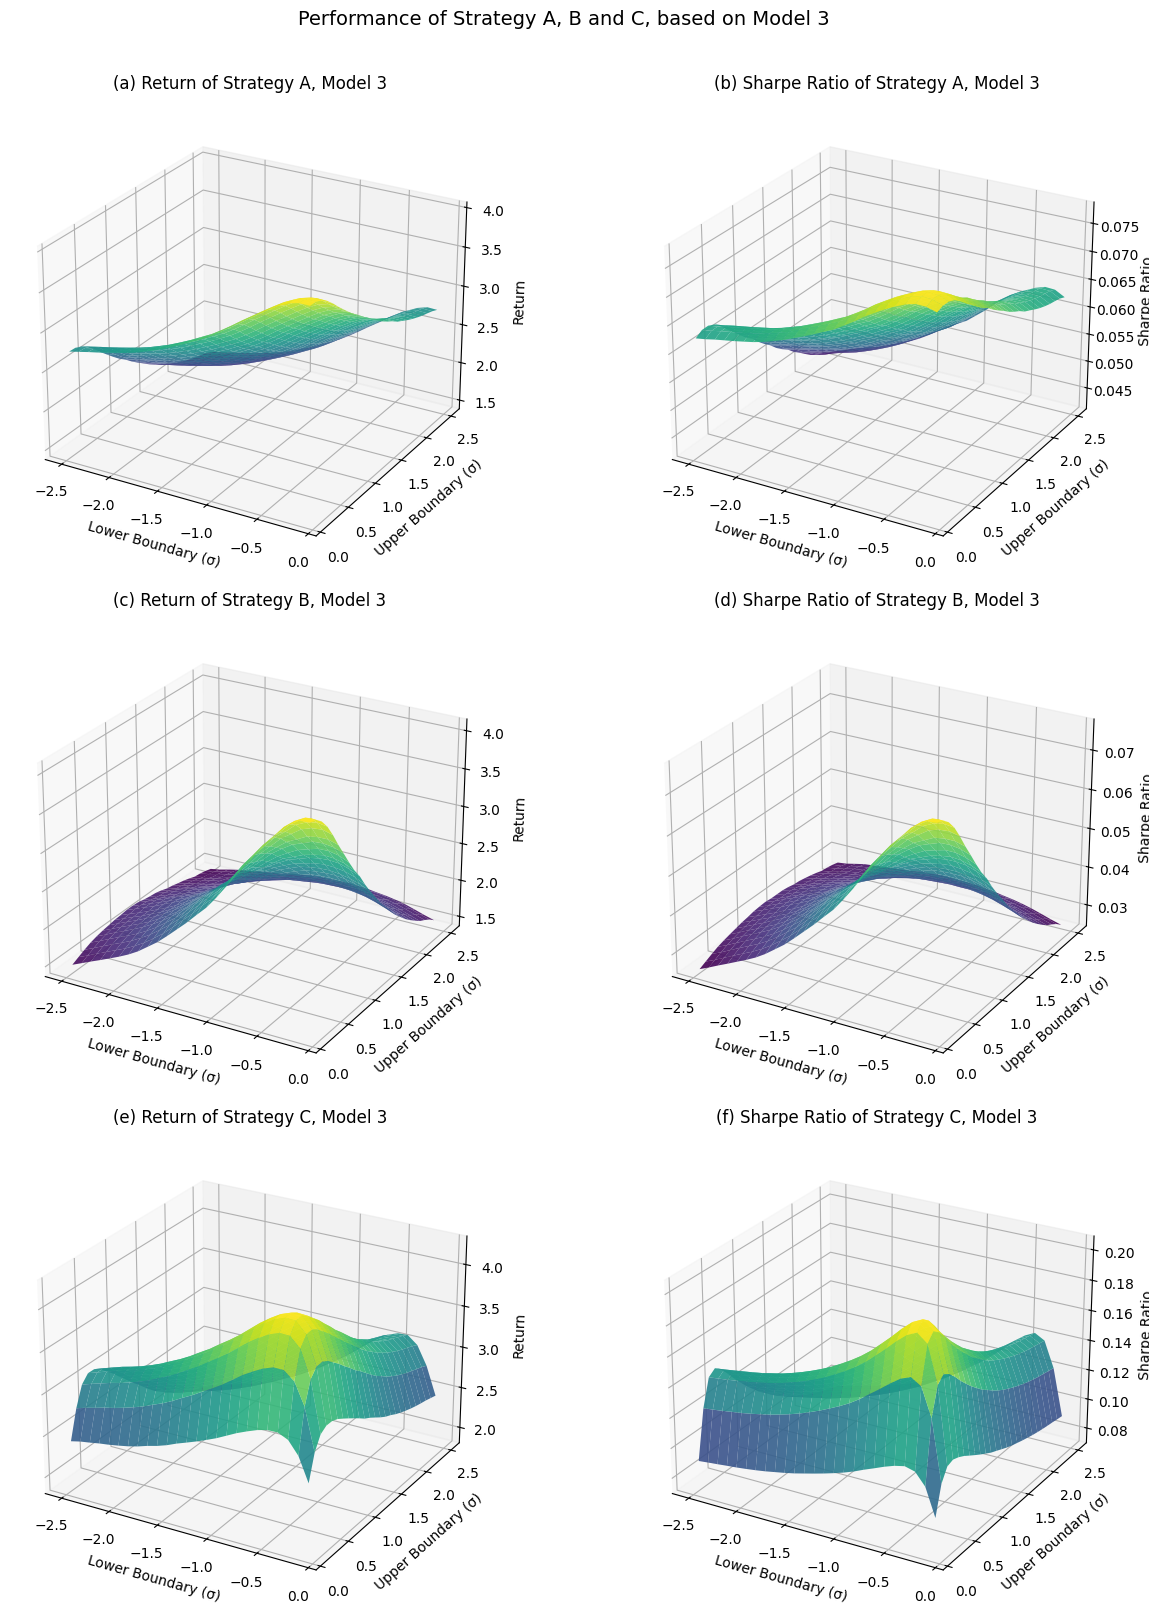

In [11]:
# Plot Model 3 (Heteroscedastic - most interesting!)
fig3 = plot_model_surfaces('Model 3', surfaces['model3'])
plt.show()

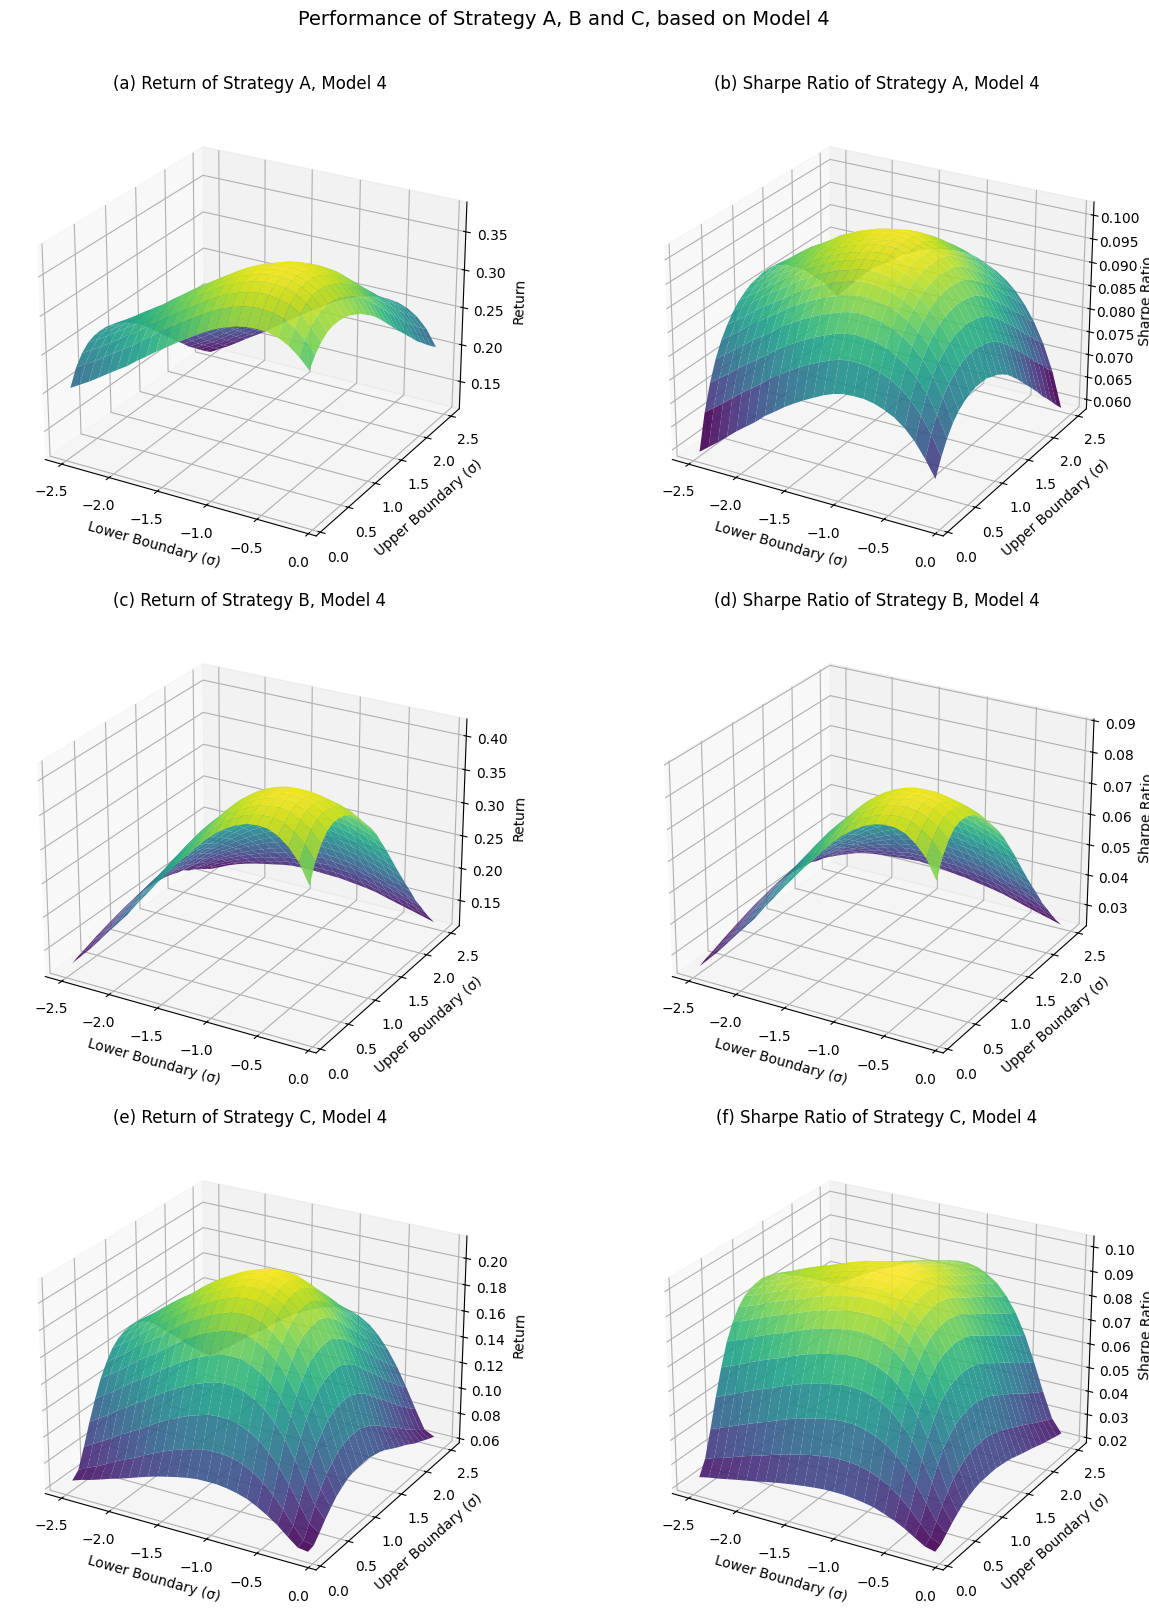

In [12]:
# Plot Model 4
fig4 = plot_model_surfaces('Model 4', surfaces['model4'])
plt.show()

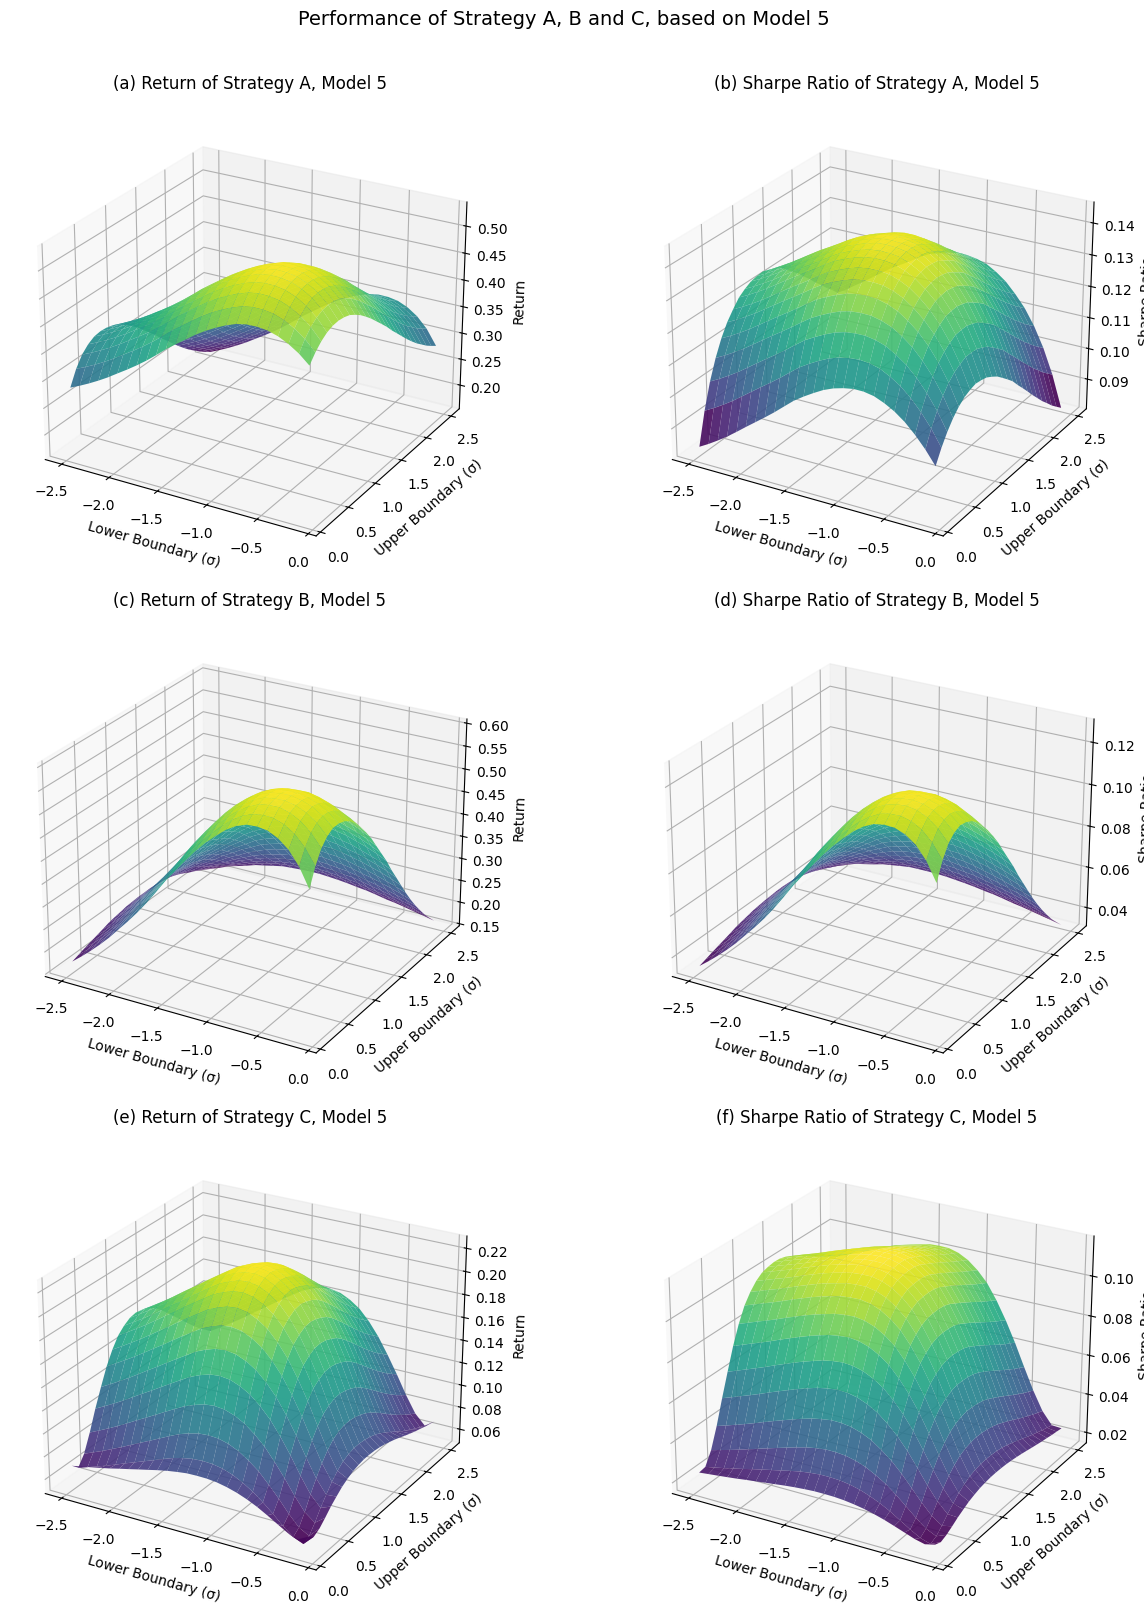


📊 All 5 model surface plots generated!
These correspond to Figures A1-A5 in the paper's appendix.


In [13]:
# Plot Model 5
fig5 = plot_model_surfaces('Model 5', surfaces['model5'])
plt.show()

print("\n📊 All 5 model surface plots generated!")
print("These correspond to Figures A1-A5 in the paper's appendix.")